In [1]:
import os, subprocess, sys, pkg_resources

required = {'numpy', 'astropy', 'agnpy'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
if missing:
    subprocess.check_call([sys.executable, '-m','pip','install','--quiet',*missing])

import numpy as np
from astropy.constants import m_e
from astropy.coordinates import Distance
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image


#### AGNpy classes ####
from agnpy.spectra import PowerLaw
from agnpy.emission_regions import Blob
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton
import warnings
warnings.filterwarnings('ignore')

def plot_setup(log_scale = 'none'):
    
    if log_scale == 'x':
        ax.set_xscale('log')
        
    elif log_scale == 'y':
        ax.set_yscale('log')
        
    elif log_scale == 'both':
        ax.set_xscale('log')
        ax.set_yscale('log')
        
    ax.tick_params(which = 'both', direction = 'in', top = True, right = True,
                  grid_alpha = 0.5, grid_linestyle = '--')
    ax.grid(True)



#### size variation

In [2]:
# Define the blob

# Emission Region Parameters:
R_bs = np.power(10., np.arange(13,19.1, .1)) * u.cm                    
V_bs = 4/3 * np.pi * np.power(R_bs, 3) 
z = Distance(1e27, unit = u.cm).z    
delta_D = 10                         
Gamma = 10                           
B = 1 * u.G                         

# Electron distribution
W_e = 1e48 * u.Unit('erg')

n_es = []
for V_b in V_bs:
    n_e = PowerLaw.from_total_energy(W = W_e, V = V_b, p = 2.5,
                                 gamma_min = 1e2, gamma_max = 1e5, mass = m_e)
    n_es.append(n_e)
# Define the emission region
blobs = []
for i, R_b in enumerate(R_bs):
    blob = Blob(R_b, z, delta_D, Gamma, B, n_e = n_es[i])
    blobs.append(blob)

In [3]:
nu = np.logspace(8, 30) * u.Hz
seds = []
for i in range(len(R_bs)):

    blob = blobs[i]
    synch = Synchrotron(blob, ssa = True)
    synch_sed = synch.sed_flux(nu)
    
    ssc = SynchrotronSelfCompton(blob, ssa = True)
    ssc_sed = ssc.sed_flux(nu)

    total_sed = synch_sed + ssc_sed
    seds.append(total_sed)


(1e-16, 0.01)

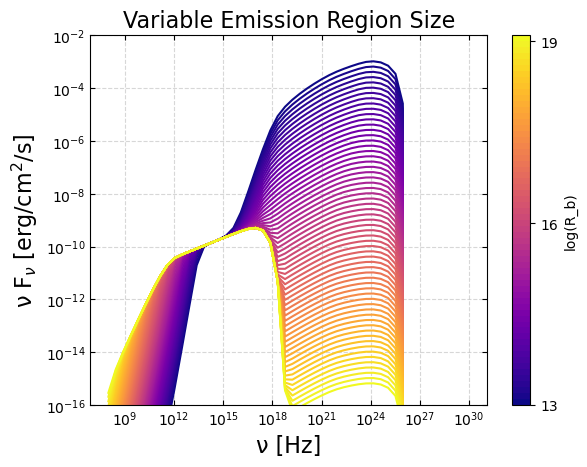

In [4]:
fig, ax = plt.subplots()

cmap = mpl.cm.get_cmap('plasma', len(R_bs))

# make a dummie mappable for the colorbar
c = np.arange(1, len(R_bs)+1)
v = [float(np.log10(_.value)) for _ in R_bs]
dummie_cax = ax.scatter(c, c, c = v, cmap = cmap)

# clear axis
ax.cla()

plot_setup('both')

for j, R_b in enumerate(R_bs):
    
    ax.plot(nu, seds[j], color = cmap(j))
fig.colorbar(dummie_cax, ticks = [v[0], v[30], v[60]], label = 'log(R_b)')

ax.set_xlabel('ν [Hz]',fontsize = 16)
ax.set_ylabel(r'ν F$_{\nu}$ [erg/cm$^{2}$/s]', fontsize = 16)
ax.set_title('Variable Emission Region Size', fontsize = 16)
ax.set_ylim(1e-16, 1e-2)

#### variable redshift

In [11]:
# Define the blob

# Emission Region Parameters:
R_b = 1e16 * u.cm
V_b = 4/3 * np.pi * np.power(R_b, 3) 
# This range covers redshifts in ~[0.05, 4.]
dists = np.power(10., np.arange(26.5, 29.1, 0.1))

redshifts = []
for dist in dists:
        
    z = Distance(dist, unit = u.cm).z    
    redshifts.append(z)
    
delta_D = 10                         
Gamma = 10                           
B = 1 * u.G                         

# Electron distribution
W_e = 1e48 * u.Unit('erg')

n_e = PowerLaw.from_total_energy(W = W_e, V = V_b, p = 2.5,
                                 gamma_min = 1e2, gamma_max = 1e5, mass = m_e)


# Define the emission region
blobs = []
for z in redshifts:
    blob = Blob(R_b, z, delta_D, Gamma, B, n_e = n_e)
    blobs.append(blob)

In [12]:
nu = np.logspace(8, 30) * u.Hz
seds = []
for blob in blobs:

    synch = Synchrotron(blob, ssa = True)
    synch_sed = synch.sed_flux(nu)
    
    ssc = SynchrotronSelfCompton(blob, ssa = True)
    ssc_sed = ssc.sed_flux(nu)

    total_sed = synch_sed + ssc_sed
    seds.append(total_sed)


(1e-16, 1e-07)

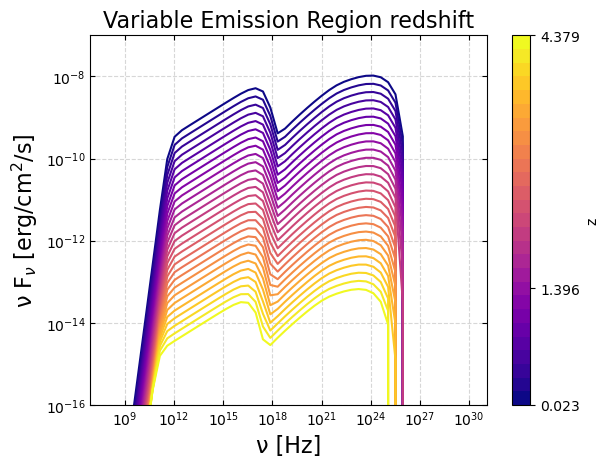

In [15]:
fig, ax = plt.subplots()

cmap = mpl.cm.get_cmap('plasma', len(redshifts))

# make a dummie mappable for the colorbar
c = np.arange(1, len(redshifts)+1)
v = [float(_.value) for _ in redshifts]
dummie_cax = ax.scatter(c, c, c = v, cmap = cmap)

# clear axis
ax.cla()

plot_setup('both')

for j, z in enumerate(redshifts):
    
    ax.plot(nu, seds[j], color = cmap(j))
fig.colorbar(dummie_cax, ticks = [v[0], v[20], v[26]], label = 'z')

ax.set_xlabel('ν [Hz]',fontsize = 16)
ax.set_ylabel(r'ν F$_{\nu}$ [erg/cm$^{2}$/s]', fontsize = 16)
ax.set_title('Variable Emission Region redshift', fontsize = 16)
ax.set_ylim(1e-16, 1e-7)

#### Magnetic field variation 

In [16]:
# Define the blob

# Emission Region Parameters:
R_b = 1e16 * u.cm                    
V_b = 4/3 * np.pi * np.power(R_b, 3) 
z = Distance(1e27, unit = u.cm).z    
delta_D = 10                         
Gamma = 10                  
Bs = np.arange(0.5, 1.5, 0.01)                                             

# Electron distribution
W_e = 1e48 * u.Unit('erg')

n_e = PowerLaw.from_total_energy(W = W_e, V = V_b, p = 2.8,
                                 gamma_min = 1e2, gamma_max = 1e5, mass = m_e)

# Define the emission region
blobs = []
for B in Bs:
    this_B = B * u.G
    blob = Blob(R_b, z, delta_D, Gamma, this_B, n_e = n_e)
    blobs.append(blob)

In [17]:
nu = np.logspace(8, 30) * u.Hz
seds = []
for blob in blobs:

    synch = Synchrotron(blob, ssa = True)
    synch_sed = synch.sed_flux(nu)
    
    ssc = SynchrotronSelfCompton(blob, ssa = True)
    ssc_sed = ssc.sed_flux(nu)

    total_sed = synch_sed + ssc_sed
    seds.append(total_sed)


(4e-12, 1e-09)

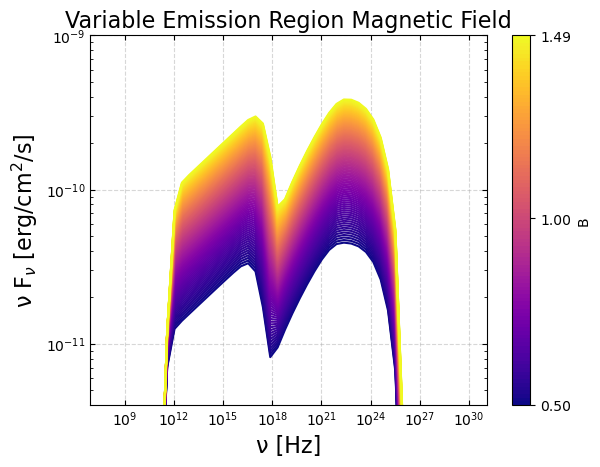

In [21]:
fig, ax = plt.subplots()

cmap = mpl.cm.get_cmap('plasma', len(Bs))

# make a dummie mappable for the colorbar
c = np.arange(1, len(Bs)+1)
v = [float(_) for _ in Bs]
dummie_cax = ax.scatter(c, c, c = v, cmap = cmap)

# clear axis
ax.cla()

plot_setup('both')

for j, z in enumerate(Bs):
    
    ax.plot(nu, seds[j], color = cmap(j))
fig.colorbar(dummie_cax, ticks = [v[0], v[50], v[99]], label = 'B')

ax.set_xlabel('ν [Hz]',fontsize = 16)
ax.set_ylabel(r'ν F$_{\nu}$ [erg/cm$^{2}$/s]', fontsize = 16)
ax.set_title('Variable Emission Region Magnetic Field', fontsize = 16)
ax.set_ylim(1e-12, 1e-9)

#### Lorentz/Doppler factors

In [22]:
# Define the blob

# Emission Region Parameters:
R_b = 1e16 * u.cm                    
V_b = 4/3 * np.pi * np.power(R_b, 3) 
z = Distance(1e27, unit = u.cm).z    
delta_D = np.power(10, np.arange(np.log10(5), np.log10(100), 0.01))                    
Gamma = np.power(10, np.arange(np.log10(5), np.log10(100), 0.01))                  
B = 1. * u.G                                        

# Electron distribution
W_e = 1e48 * u.Unit('erg')

n_e = PowerLaw.from_total_energy(W = W_e, V = V_b, p = 2.8,
                                 gamma_min = 1e2, gamma_max = 1e5, mass = m_e)

# Define the emission region
blobs = []
for i in range(len(Gamma)):
    blob = Blob(R_b, z, delta_D[i], Gamma[i], B, n_e = n_e)
    blobs.append(blob)

In [23]:
nu = np.logspace(8, 30) * u.Hz
seds = []
for blob in blobs:

    synch = Synchrotron(blob, ssa = True)
    synch_sed = synch.sed_flux(nu)
    
    ssc = SynchrotronSelfCompton(blob, ssa = True)
    ssc_sed = ssc.sed_flux(nu)

    total_sed = synch_sed + ssc_sed
    seds.append(total_sed)


(1e-14, 1e-05)

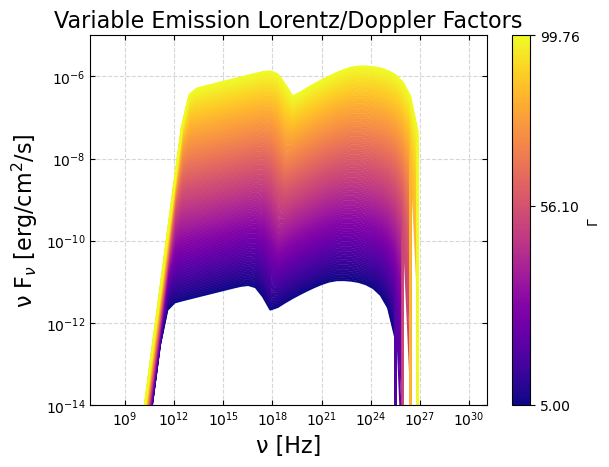

In [27]:
fig, ax = plt.subplots()

cmap = mpl.cm.get_cmap('plasma', len(Gamma))

# make a dummie mappable for the colorbar
c = np.arange(1, len(Gamma)+1)
v = [float(_) for _ in Gamma]
dummie_cax = ax.scatter(c, c, c = v, cmap = cmap)

# clear axis
ax.cla()

plot_setup('both')

for j, z in enumerate(Gamma):
    
    ax.plot(nu, seds[j], color = cmap(j))
fig.colorbar(dummie_cax, ticks = [v[0], v[105], v[130]], label = 'Γ')

ax.set_xlabel('ν [Hz]',fontsize = 16)
ax.set_ylabel(r'ν F$_{\nu}$ [erg/cm$^{2}$/s]', fontsize = 16)
ax.set_title('Variable Emission Lorentz/Doppler Factors', fontsize = 16)
ax.set_ylim(1e-14, 1e-5)